In [1]:
import mesa

## Introduction (Obesity Example)
This code may help get you define an agent-based model to study the influence of social norms on obesity. The model simulates a population of people (agents) with various attributes such as age, gender, BMI, and social connections (family, colleagues, friends, hobbies, and self). The agents' BMI changes over time based on their diet and exercise habits, while their perception of obesity is influenced by their social connections. The social norms are modeled based on the perception of obesity of an agent's social connections, and the agent's perception of obesity is updated based on the perception of obesity of their social connections. The model outputs the count of agents in each BMI category (underweight, normal, overweight) at each step.

The code imports the required libraries and defines the Person and SocialNorms classes as agents and the model, respectively, using the Mesa library. The Person class has attributes such as age, gender, BMI, and connections, along with methods to update BMI and perception of obesity. The SocialNorms class has parameters such as the number of people, average BMI, and connection probabilities, along with methods to create people, connect them, and initialize BMI. The step method updates the model by collecting data, updating agents' perceptions, and advancing the simulation by one time step.

In [32]:
from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
from mesa.time import RandomActivation
import networkx as nx
import numpy as np


class Person(Agent):
    def __init__(self, unique_id, model, age, gender, bmi, connections):
        super().__init__(unique_id, model)
        self.age = age
        self.gender = gender
        self.bmi = bmi
        self.connections = connections

    def step(self):
        self.update_bmi()
        self.update_perception_of_obesity()

    def update_bmi(self):
        # Define how an agent's BMI changes over time
        pass

    def update_perception_of_obesity(self):
        # Define how an agent's perception of obesity changes over time
        pass

class Person(Agent):
    def __init__(self, unique_id, model, age, gender, bmi, connections):
        super().__init__(unique_id, model)
        self.age = age
        self.gender = gender
        self.bmi = bmi
        self.connections = connections
        self.perception_of_obesity = self.get_perception_of_obesity()

    def get_perception_of_obesity(self):
        if self.bmi < 18.5:
            return 'underweight'
        elif self.bmi < 25:
            return 'normal'
        elif self.bmi < 30:
            return 'overweight'
        else:
            return 'obese'

    def update_bmi(self):
        # Define how an agent's BMI changes over time
        # For example, BMI may increase or decrease by a random amount
        # based on an agent's diet and exercise habits
        delta_bmi = np.random.normal(loc=0, scale=0.1)
        self.bmi += delta_bmi

    def update_perception_of_obesity(self):
        # Define how an agent's perception of obesity changes over time
        # For example, an agent may become more concerned about their weight
        # if they receive negative feedback from their social connections
        # about their appearance or health
        self.perception_of_obesity = self.get_perception_of_obesity()
        for conn_type, conn_list in self.connections.items():
            for conn in conn_list:
                if conn is not None and conn.perception_of_obesity == 'obese':
                    if conn_type == 'family':
                        self.perception_of_obesity = 'obese'
                    elif conn_type == 'colleagues':
                        self.perception_of_obesity = 'overweight'
                    elif conn_type == 'friends':
                        self.perception_of_obesity = np.random.choice(['overweight', 'obese'],
                                                                       p=[0.8, 0.2])
                    elif conn_type == 'hobbies':
                        self.perception_of_obesity = np.random.choice(['normal', 'overweight', 'obese'],
                                                                       p=[0.5, 0.3, 0.2])


class SocialNorms(Model):
    def __init__(self, num_people, avg_bmi, family_conn_prob, colleague_conn_prob, friend_conn_prob, hobby_conn_prob):
        self.num_people = num_people
        self.avg_bmi = avg_bmi
        self.family_conn_prob = family_conn_prob
        self.colleague_conn_prob = colleague_conn_prob
        self.friend_conn_prob = friend_conn_prob
        self.hobby_conn_prob = hobby_conn_prob
        self.schedule = RandomActivation(self)
        self.grid = NetworkGrid(nx.Graph())
        self.datacollector = DataCollector(
            model_reporters={
                "Underweight": lambda m: self.count_perception_of_obesity(m, 'underweight'),
                "Normal": lambda m: self.count_perception_of_obesity(m, 'normal'),
                "Overweight": lambda m: self.count_perception_of_obesity(m, 'overweight')
            }
        )
        self.create_people()
        self.connect_people()
        self.initialize_bmi()

    def connect_people(self):
        for person in self.schedule.agents:
            for other_person in self.schedule.agents:
                if person != other_person:
                    if np.random.random() < self.family_conn_prob:
                        person.connections['family'].append(other_person)
                    if np.random.random() < self.colleague_conn_prob:
                        person.connections['colleagues'].append(other_person)
                    if np.random.random() < self.friend_conn_prob:
                        person.connections['friends'].append(other_person)
                    if np.random.random() < self.hobby_conn_prob:
                        person.connections['hobbies'].append(other_person)

    def create_people(self):
        for i in range(self.num_people):
            age = np.random.normal(35, 15)
            gender = np.random.choice(['male', 'female'])
            bmi = np.random.normal(self.avg_bmi, 5)
            connections = {'family': [], 'colleagues': [], 'friends': [], 'hobbies': [], 'self': None}
            person = Person(i, self, age, gender, bmi, connections)
            self.schedule.add(person)
            if len(self.grid.G.nodes) > 0:
                self.grid.place_agent(person, np.random.choice(list(self.grid.G.nodes)))



    def initialize_bmi(self):
        for person in self.schedule.agents:
            while person.bmi < 15 or person.bmi > 40:
                person.bmi = np.random.normal(self.avg_bmi, 2)

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def count_perception_of_obesity(self, model, category):
        count = 0
        for person in model.schedule.agents:
            if person.perception_of_obesity == category:
                count += 1
        return count


In [33]:
model = SocialNorms(num_people=100, avg_bmi=25, family_conn_prob=0.8,
colleague_conn_prob=0.5, friend_conn_prob=0.5, hobby_conn_prob=0.2)

for i in range(50):
    model.step()

<Axes: >

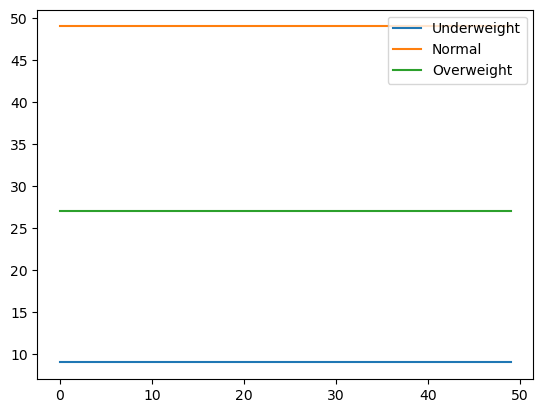

In [34]:
perception_data = model.datacollector.get_model_vars_dataframe()
perception_data.plot()

In this very simple example, the proportions of 'Underweight', 'Normal', and 'Overweight' are fixed over time because they are based on the initial distribution of BMI in the population. As the model runs, people's BMIs may change, but the proportions of 'Underweight', 'Normal', and 'Overweight' will remain the same unless there are changes in the way people perceive obesity or in the way social norms are enforced.

### Additional behaviors or interactions that you may want to consider including in your social norms model:

Health behaviors: You could model how agents' behaviors, such as physical activity, eating habits, or smoking, influence their BMI and how these behaviors are influenced by their social connections.

Social influence: You could model how agents' social connections influence their attitudes and beliefs about obesity, and how this affects their BMI. For example, an agent may adopt the eating habits or physical activity levels of their social connections.

Network dynamics: You could model how the social network changes over time and how this affects the spread of social norms related to obesity. For example, an agent may form new connections or sever existing ones based on their BMI or their social norms.

Individual differences: You could model individual differences in susceptibility to social influence and how these differences affect the spread of social norms related to obesity. For example, some agents may be more or less susceptible to peer pressure than others.

To make the model more interesting, we could introduce some additional factors that affect people's BMIs and their perception of obesity. For example, we could incorporate the influence of media and advertising on people's dietary habits, the availability of healthy food options in different social settings, or the impact of physical activity levels on BMI.

Another option would be to introduce changes in social norms over time, such as shifts in cultural attitudes towards body size or changes in the influence of different social networks on people's perception of obesity. We could also model the effects of policies aimed at changing social norms, such as public health campaigns or regulations on food advertising.

Incorporating these additional factors could make the model more realistic and dynamic, and allow us to explore the complex interactions between individual behaviors, social norms, and external influences on health outcomes.


## Introduction (Alcohol Consumption Example)

Alcohol consumption is a significant public health issue and a leading cause of preventable death and illness worldwide. The social environment, including peer norms and motives, is a crucial factor influencing alcohol consumption. Computational modeling provides a powerful tool for understanding the complex interplay between individual and social factors in shaping alcohol consumption behavior. In this hackathon, we will explore the role of social norms and motives in predicting alcohol consumption using agent-based modeling.

## Setup:

We will start by defining a Person class that represents an agent in our model. Each person has attributes such as their age, gender, and drinking behavior. We will use a simple approach where the person's drinking behavior is represented as a continuous variable between 0 and 1, where 0 represents abstaining from alcohol, and 1 represents heavy drinking. The person's perception of social norms and motives will also be represented as continuous variables between 0 and 1.

Next, we will define a SocialNorms class that represents the agent-based model. The model will consist of a population of Person agents who are connected to each other through social networks. The social networks will be represented as a graph, where each person's connections will be determined by the type of relationship they have with others (e.g., friends, family, colleagues).

The SocialNorms model will simulate the spread of social norms and motives within the population over time. At each time step, each person's drinking behavior will be updated based on their current perception of social norms and motives and their susceptibility to social influence. We will use a simple model where the person's drinking behavior is influenced by the average drinking behavior of their social network, with the strength of influence depending on the type of relationship (e.g., close friends have a stronger influence than distant acquaintances).

We will start with the person class

In [ ]:
class Person:
    def __init__(self, age, gender, drinking_behavior, social_norms, social_motives):
        self.age = age
        self.gender = gender
        self.drinking_behavior = drinking_behavior
        self.social_norms = social_norms
        self.social_motives = social_motives


Next, we will define the SocialNorms class:

In [ ]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
import networkx as nx
import random

class SocialNorms(Model):
    def __init__(self, num_agents):
        self.num_agents = num_agents
        self.schedule = RandomActivation(self)
        self.grid = NetworkGrid(nx.Graph())
        self.network = self.create_social_network()
        self.create_agents()

    def create_social_network(self):
        network = nx.Graph()
        network.add_nodes_from(range(self.num_agents))
        for i in range(self.num_agents):
            for j in range(i+1, self.num_agents):
                if random.random() < 0.3:
                    network.add_edge(i, j)
        return network

    def create_agents(self):
        for i in range(self.num_agents):
            age = random.randint(18, 65)
            drinking_behavior = random.random()
            social_norms = random.random()
            social_motives = random.random()
            agent = Person(age, gender, drinking_behavior, social_norms, social_motives)
            self.schedule.add(agent)
            self.grid.place_agent(agent, i)


Now, we will define the get_opinion function that updates each person's drinking behavior based on their current perception of social norms and motives:

In [ ]:
def get_opinion(self):
    """Calculate the agent's opinion on alcohol consumption based on their own 
    behavior and the behavior of their peers, taking into account their 
    susceptibility to social influence.
    """
    peer_alcohol = [n.get_alcohol() for n in self.get_peers()]
    num_peers = len(peer_alcohol)
    
    if self.alcohol:
        # Agent drinks alcohol
        if num_peers == 0:
            # No peers to compare to
            return 1
        else:
            # Compare to peers and adjust based on susceptibility to social influence
            peer_avg = sum(peer_alcohol) / num_peers
            return self.alcohol_influence * (self.alcohol / peer_avg) + (1 - self.alcohol_influence)
    else:
        # Agent does not drink alcohol
        if num_peers == 0:
            # No peers to compare to
            return 0
        else:
            # Compare to peers and adjust based on susceptibility to social influence
            peer_avg = sum(peer_alcohol) / num_peers
            return self.alcohol_influence * (1 - self.alcohol / peer_avg) + (1 - self.alcohol_influence)


Alcohol consumption is a complex behavior that is influenced by a multitude of factors, including individual differences in susceptibility to social influence, social norms, and social motives. Social norms, which are the unwritten rules of behavior that are followed by members of a group or society, can be strong predictors of alcohol consumption behavior among college students. 

For inspiration, see https://doi.org/10.1016/j.addbeh.2012.07.004). This study found that both descriptive norms (i.e., the perceived prevalence of alcohol consumption) and injunctive norms (i.e., the perceived approval of drinking by peers) independently predicted alcohol consumption among college students. Furthermore, injunctive norms were further divided into distal (socially distant peers) and proximal (socially close peers), and proximal injunctive norms were found to have a stronger effect on drinking behavior than distal injunctive norms.

In this hackathon, we will create an Agent-Based Model (ABM) to investigate how social norms and individual differences in susceptibility to social influence affect alcohol consumption behavior. 

One idea is to model a population of college students who are connected to each other through social networks, and whose alcohol consumption behavior is influenced by their own behavior as well as the behavior of their peers.

We could define a Person class that represents a college student, and a SocialNorms class that represents the ABM. The Person class could have attributes such as alcohol consumption behavior, susceptibility to social influence, and social network connections. The SocialNorms class would create a population of Person agents, assign them to social networks, and simulate the spread of alcohol consumption behavior through the networks over time.